In [1]:
import networkx as nx
import numpy as np
import torch
from test_model import CaT
from CaT.datasets import reorder_dag, get_full_ordering
from utils.inference import CausalInference
import matplotlib.pyplot as plt
from datasets import get_full_ordering, reorder_dag

shuffling = 0
seed = 1
standardize = 0
sample_size = 100000
batch_size = 100
max_iters = 100000
eval_interval = 100
eval_iters = 100
validation_fraction = 0.3
np.random.seed(seed=seed)
torch.manual_seed(seed)
device = 'cuda'
dropout_rate = 0.0
learning_rate = 5e-3
ff_n_embed = 6
num_heads = 2
n_layers = 2
embed_dim = 5
head_size = 6


We create data from a 'true' DAG (which is DAGnx3 below) but also provide two other DAGs which are incorrect in different ways. DAGnx1 is fully exogenous, and DAGnx2 has one missing edge and another directed edge reversed.

We imagine we are interested in the 'total' effect of X -> Y.  As these simulations are linear, this effect can be calculated easily by hand.

In the case where X1 -> Y and X1 -> X2 -> Y, the total effect is the sum of the effect from both paths. e.g. if X1 -> Y has a coefficient of  0.8,  X1 -> X2 of 0.8, and X2 -> Y of 0.7, then the total effect is 0.8 + (0.8 x 0.7) = 1.36

In [2]:
def generate_data(N, d=1):
    DAGnx1 = nx.DiGraph()
    DAGnx2 = nx.DiGraph()
    DAGnx3 = nx.DiGraph()  # correct graph
    
    Ux1 = np.random.randn(N,d)
    X1 =  Ux1

    Ux2 = np.random.randn(N,d)
    X2 =  0.8 * X1 + Ux2
    
    X20 = Ux2
    X21 = 0.8 + Ux2

    Uy = np.random.randn(N,d)
    Y =  0.8 * X1 + 0.4 * X2 + Uy
    
    Ux3 = np.random.randn(N,d)
    X3 = 0.7 * Y + 0.6 * X1 + Ux3

    Y0 = 0.4 * X20 + Uy 
    Y1 = 0.8 + 0.4 * X21 + Uy

    all_data_dict = {'X1': X1, 'X2': X2, 'X3': X3, 'Y': Y}

    # types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
    var_types = {'X1': 'cont', 'X2': 'cont', 'X3': 'cont', 'Y': 'cont'}

    DAGnx1.add_edges_from([('X1', 'Y'), ('X2', 'Y'), ('X3', 'Y')])
    DAGnx1 = reorder_dag(dag=DAGnx1)  # topologically sorted dag
    var_names1 = list(DAGnx1.nodes())  # topologically ordered list of variables
    all_data1 = np.stack([all_data_dict[key] for key in var_names1], axis=1)
    causal_ordering1 = get_full_ordering(DAGnx1)
    ex_dag_stuff = (all_data1, DAGnx1, var_names1, causal_ordering1, var_types)
    
    DAGnx2.add_edges_from([('X1', 'Y'), ('X1', 'X2'), ('X2', 'Y'), ('X3', 'Y')])
    DAGnx2 = reorder_dag(dag=DAGnx2)  # topologically sorted dag
    var_names2 = list(DAGnx2.nodes())  # topologically ordered list of variables
    all_data2 = np.stack([all_data_dict[key] for key in var_names2], axis=1)
    causal_ordering2 = get_full_ordering(DAGnx2)
    mediated_dag_stuff = (all_data2, DAGnx2, var_names2, causal_ordering2, var_types)
    
    DAGnx3.add_edges_from([('X1', 'Y'), ('X1', 'X2'), ('X1', 'X3'), ('X2', 'Y'), ('Y', 'X3')])
    DAGnx3 = reorder_dag(dag=DAGnx3)  # topologically sorted dag
    var_names3 = list(DAGnx3.nodes())  # topologically ordered list of variables
    all_data3 = np.stack([all_data_dict[key] for key in var_names3], axis=1)
    causal_ordering3 = get_full_ordering(DAGnx3)
    correct_dag_stuff =  (all_data3, DAGnx3, var_names3, causal_ordering3, var_types)

    return ex_dag_stuff, mediated_dag_stuff, correct_dag_stuff, Y0, Y1

d=1
_, _, _, Y0, Y1 = generate_data(N=1000000, d=d)
ATE = (Y1 - Y0).mean(0)  
ex_dag_stuff, mediated_dag_stuff, correct_dag_stuff, Y0, Y1 = generate_data(N=sample_size, d=d)

all_data1, DAGnx1, var_names1, causal_ordering1, var_types1 = ex_dag_stuff
all_data2, DAGnx2, var_names2, causal_ordering2, var_types2 = mediated_dag_stuff
all_data3, DAGnx3, var_names3, causal_ordering3, var_types3 = correct_dag_stuff

print(var_names1, 'ATE of X1 on Y:', ATE)
print(all_data1.shape)

['X1', 'X2', 'X3', 'Y'] ATE of X1 on Y: [1.12]
(100000, 4, 1)


Incorrect DAG 1:


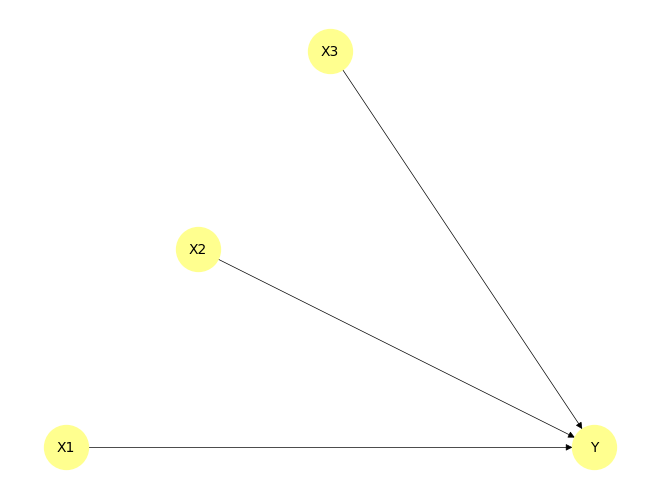

Incorrect DAG 2:


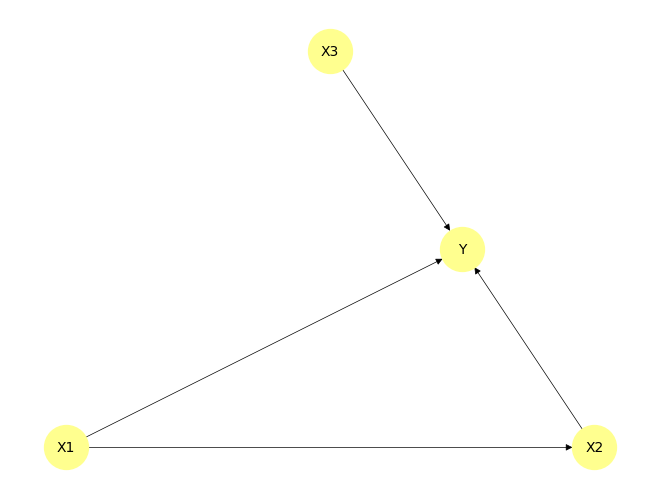

Correct DAG:


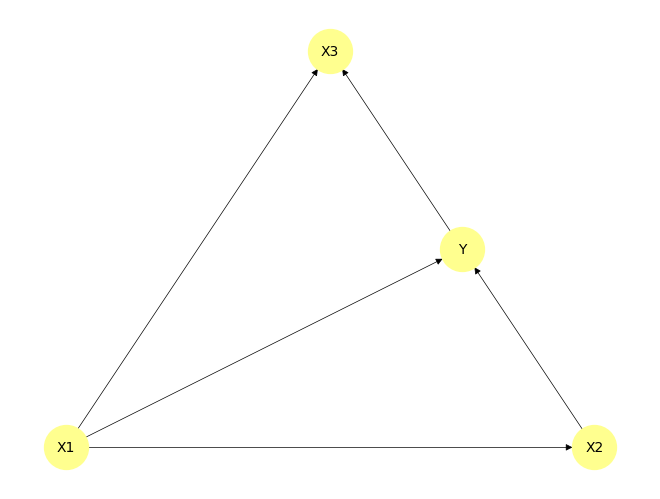

In [3]:
print('Incorrect DAG 1:')
nx.draw_planar(
    DAGnx1,
    with_labels=True,
    node_size=1000,
    node_color="#ffff8f",
    width=0.5,
    font_size=10,
)
plt.show()

print('Incorrect DAG 2:')
nx.draw_planar(
    DAGnx2,
    with_labels=True,
    node_size=1000,
    node_color="#ffff8f",
    width=0.5,
    font_size=10,
)
plt.show()

print('Correct DAG:')
nx.draw_planar(
    DAGnx3,
    with_labels=True,
    node_size=1000,
    node_color="#ffff8f",
    width=0.5,
    font_size=10,
)
plt.show()

We run the model with the same data each time (although the column ordering of the data is different in each case, according to the assumed underlying DAG), and provide fit statistics as well as estimated causal links.

### Incorrect DAG 1 (fully exogenous)

In [4]:
indices = np.arange(0, len(all_data1))
np.random.shuffle(indices)

val_inds = indices[:int(validation_fraction*len(indices))]
train_inds = indices[int(validation_fraction*len(indices)):]
train_data = all_data1[train_inds]
val_data = all_data1[val_inds]
train_data, val_data = torch.from_numpy(train_data).float(),  torch.from_numpy(val_data).float()

input_dim = all_data1.shape[2]

model1 = CaT(input_dim=input_dim,
                    dropout_rate=dropout_rate,
                    head_size=head_size,
                    num_heads=num_heads,
                    ff_n_embed=ff_n_embed,
                    embed_dim= embed_dim,
                    dag=DAGnx1,
                    causal_ordering=causal_ordering1,
                    n_layers=n_layers,
                    device=device,
                    var_types=var_types1, activation_function='Swish'
                    ).to(device)

optimizer = torch.optim.AdamW(model1.parameters(), lr=learning_rate)

def get_batch(train_data, val_data, split, device, batch_size):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, len(data), (batch_size,))
    x = data[ix]
    return x.to(device)

all_var_losses = {}
for iter_ in range(0, max_iters):
    # train and update the model
    model1.train()

    xb = get_batch(train_data=train_data, val_data=val_data, split='train', device=device, batch_size=batch_size)
    xb_mod = torch.clone(xb.detach())
    X, loss, loss_dict = model1(X=xb, targets=xb_mod
                                )

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


    if iter_ % eval_interval == 0:  # evaluate the loss (no gradients)
        for key in loss_dict.keys():
            if key not in all_var_losses.keys():
                all_var_losses[key] = []
            all_var_losses[key].append(loss_dict[key])

        model1.eval()
        eval_loss = {}
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):

                xb = get_batch(train_data=train_data, val_data=val_data, split=split, device=device,
                               batch_size=batch_size)
                xb_mod = torch.clone(xb.detach())
                X, loss, loss_dict = model1(X=xb, targets=xb_mod)
                losses[k] = loss.item()
            eval_loss[split] = losses.mean()
        model1.train()
        print(f"step {iter_} of {max_iters}: train_loss {eval_loss['train']:.4f}, val loss {eval_loss['val']:.4f}")
 

step 0 of 100000: train_loss 2.8259, val loss 2.8164
step 100 of 100000: train_loss 0.7318, val loss 0.7099
step 200 of 100000: train_loss 0.6667, val loss 0.6978
step 300 of 100000: train_loss 0.6625, val loss 0.6878
step 400 of 100000: train_loss 0.6685, val loss 0.6914
step 500 of 100000: train_loss 0.6800, val loss 0.6780
step 600 of 100000: train_loss 0.6558, val loss 0.6767
step 700 of 100000: train_loss 0.6747, val loss 0.6953
step 800 of 100000: train_loss 0.6599, val loss 0.6855
step 900 of 100000: train_loss 0.6881, val loss 0.6945
step 1000 of 100000: train_loss 0.6769, val loss 0.6925
step 1100 of 100000: train_loss 0.6653, val loss 0.6893
step 1200 of 100000: train_loss 0.6590, val loss 0.6905
step 1300 of 100000: train_loss 0.6557, val loss 0.6872
step 1400 of 100000: train_loss 0.6582, val loss 0.6619
step 1500 of 100000: train_loss 0.7167, val loss 0.6900
step 1600 of 100000: train_loss 0.6623, val loss 0.6898
step 1700 of 100000: train_loss 0.6813, val loss 0.6859
step

/home/matthewvowels/GitHub/Causal_Transformer/utils/inference.py:53: UserWarning: No mask has been specified. If padding has been used, the absence of a mask may lead to incorrect results.
  warnings.warn(


ATE: [1.12] est ATE: [0.25587264] error: [0.86412736]
Mean Squared Error Across All Vars: tensor(1.7020)
Mean Squared Error Across Outcome: tensor(0.6635)


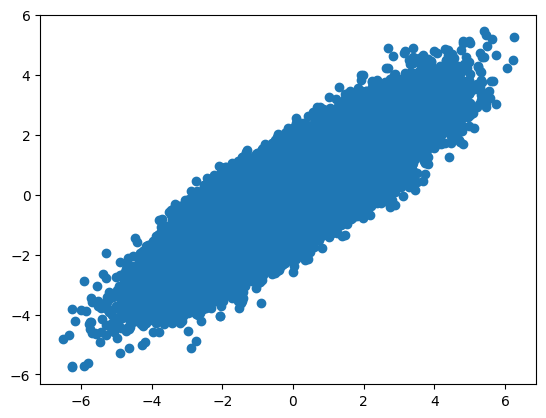

In [5]:
   
model1.eval()
inf = CausalInference(model=model1, device=device)

int_nodes_vals0 = {'X1':np.array([0.0,])}
int_nodes_vals1 = {'X1':np.array([1.0,])}
effect_var = 'Y'
effect_index = var_names1.index(effect_var)

preds0 = inf.forward(all_data1, int_nodes_vals0)
preds1 = inf.forward(all_data1, int_nodes_vals1)
ATE_pred = (preds1[:,effect_index,:] - preds0[:,effect_index,:]).mean(0)
eATE = np.abs(ATE_pred - ATE)
print('ATE:', ATE, 'est ATE:', ATE_pred, 'error:', eATE)

preds = model1(train_data.to(device))
plt.scatter(train_data[:,effect_index,-1].detach().cpu().numpy(), preds[:, effect_index, -1].detach().cpu().numpy())
print('Mean Squared Error Across All Vars:', ((train_data - preds.detach().cpu())**2).mean())
print('Mean Squared Error Across Outcome:', ((train_data[:,effect_index,:] - preds[:,effect_index,:].detach().cpu())**2).mean())

## Incorrect DAG 2 (missing and reverse edges)

In [6]:
indices = np.arange(0, len(all_data2))
np.random.shuffle(indices)

val_inds = indices[:int(validation_fraction*len(indices))]
train_inds = indices[int(validation_fraction*len(indices)):]
train_data = all_data2[train_inds]
val_data = all_data2[val_inds]
train_data, val_data = torch.from_numpy(train_data).float(),  torch.from_numpy(val_data).float()

input_dim = all_data2.shape[2]

model2 = CaT(input_dim=input_dim,
                    dropout_rate=dropout_rate,
                    head_size=head_size,
                    num_heads=num_heads,
                    ff_n_embed=ff_n_embed,
                    embed_dim= embed_dim,
                    dag=DAGnx2,
                    causal_ordering=causal_ordering2,
                    n_layers=n_layers,
                    device=device,
                    var_types=var_types2, activation_function='Swish'
                    ).to(device)

optimizer = torch.optim.AdamW(model2.parameters(), lr=learning_rate)

def get_batch(train_data, val_data, split, device, batch_size):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, len(data), (batch_size,))
    x = data[ix]
    return x.to(device)

all_var_losses = {}
for iter_ in range(0, max_iters):
    # train and update the model
    model2.train()

    xb = get_batch(train_data=train_data, val_data=val_data, split='train', device=device, batch_size=batch_size)
    xb_mod = torch.clone(xb.detach())
    X, loss, loss_dict = model2(X=xb, targets=xb_mod)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


    if iter_ % eval_interval == 0:  # evaluate the loss (no gradients)
        for key in loss_dict.keys():
            if key not in all_var_losses.keys():
                all_var_losses[key] = []
            all_var_losses[key].append(loss_dict[key])

        model2.eval()
        eval_loss = {}
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):

                xb = get_batch(train_data=train_data, val_data=val_data, split=split, device=device,
                               batch_size=batch_size)
                xb_mod = torch.clone(xb.detach())
                X, loss, loss_dict = model2(X=xb, targets=xb_mod)
                losses[k] = loss.item()
            eval_loss[split] = losses.mean()
        model2.train()
        print(f"step {iter_} of {max_iters}: train_loss {eval_loss['train']:.4f}, val loss {eval_loss['val']:.4f}")
 

step 0 of 100000: train_loss 2.8494, val loss 2.8908
step 100 of 100000: train_loss 1.6910, val loss 1.6550
step 200 of 100000: train_loss 1.6800, val loss 1.6627
step 300 of 100000: train_loss 1.6681, val loss 1.6905
step 400 of 100000: train_loss 1.6410, val loss 1.6940
step 500 of 100000: train_loss 1.6892, val loss 1.6653
step 600 of 100000: train_loss 1.6617, val loss 1.6740
step 700 of 100000: train_loss 1.6864, val loss 1.6335
step 800 of 100000: train_loss 1.6528, val loss 1.6546
step 900 of 100000: train_loss 1.6894, val loss 1.6991
step 1000 of 100000: train_loss 1.6913, val loss 1.6810
step 1100 of 100000: train_loss 1.6825, val loss 1.6878
step 1200 of 100000: train_loss 1.6856, val loss 1.6702
step 1300 of 100000: train_loss 1.6706, val loss 1.6621
step 1400 of 100000: train_loss 1.6467, val loss 1.6700
step 1500 of 100000: train_loss 1.6540, val loss 1.7096
step 1600 of 100000: train_loss 1.6849, val loss 1.6858
step 1700 of 100000: train_loss 1.6793, val loss 1.6898
step

ATE: [1.12] est ATE: [0.46268711] error: [0.65731289]
Mean Squared Error Across All Vars: tensor(1.5414)
Mean Squared Error Across Outcome: tensor(0.6715)


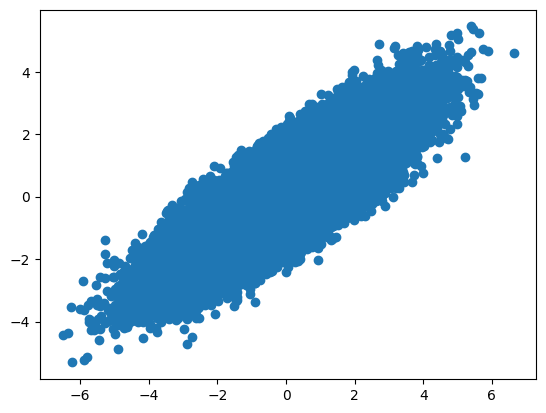

In [7]:
   
model2.eval()
inf = CausalInference(model=model2, device=device)

int_nodes_vals0 = {'X1':np.array([0.0,])}
int_nodes_vals1 = {'X1':np.array([1.0,])}
effect_var = 'Y'
effect_index = var_names2.index(effect_var)

preds0 = inf.forward(all_data2, int_nodes_vals0)
preds1 = inf.forward(all_data2, int_nodes_vals1)
ATE_pred = (preds1[:,effect_index,:] - preds0[:,effect_index,:]).mean(0)
eATE = np.abs(ATE_pred - ATE)
print('ATE:', ATE, 'est ATE:', ATE_pred, 'error:', eATE)

preds = model2(train_data.to(device))
plt.scatter(train_data[:,effect_index,-1].detach().cpu().numpy(), preds[:, effect_index, -1].detach().cpu().numpy())
print('Mean Squared Error Across All Vars:', ((train_data - preds.detach().cpu())**2).mean())
print('Mean Squared Error Across Outcome:', ((train_data[:,effect_index,:] - preds[:,effect_index,:].detach().cpu())**2).mean())

## Correct DAG

In [8]:
indices = np.arange(0, len(all_data3))
np.random.shuffle(indices)

val_inds = indices[:int(validation_fraction*len(indices))]
train_inds = indices[int(validation_fraction*len(indices)):]
train_data = all_data3[train_inds]
val_data = all_data3[val_inds]
train_data, val_data = torch.from_numpy(train_data).float(),  torch.from_numpy(val_data).float()

input_dim = all_data3.shape[2]

model3 = CaT(input_dim=input_dim,
                    dropout_rate=dropout_rate,
                    head_size=head_size,
                    num_heads=num_heads,
                    ff_n_embed=ff_n_embed,
                    embed_dim= embed_dim,
                    dag=DAGnx3,
                    causal_ordering=causal_ordering3,
                    n_layers=n_layers,
                    device=device,
                    var_types=var_types3, activation_function='Swish'
                    ).to(device)

optimizer = torch.optim.AdamW(model3.parameters(), lr=learning_rate)

def get_batch(train_data, val_data, split, device, batch_size):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, len(data), (batch_size,))
    x = data[ix]
    return x.to(device)

all_var_losses = {}
for iter_ in range(0, max_iters):
    # train and update the model
    model3.train()

    xb = get_batch(train_data=train_data, val_data=val_data, split='train', device=device, batch_size=batch_size)
    xb_mod = torch.clone(xb.detach())
    X, loss, loss_dict = model3(X=xb, targets=xb_mod)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


    if iter_ % eval_interval == 0:  # evaluate the loss (no gradients)
        for key in loss_dict.keys():
            if key not in all_var_losses.keys():
                all_var_losses[key] = []
            all_var_losses[key].append(loss_dict[key])

        model3.eval()
        eval_loss = {}
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):

                xb = get_batch(train_data=train_data, val_data=val_data, split=split, device=device,
                               batch_size=batch_size)
                xb_mod = torch.clone(xb.detach())
                X, loss, loss_dict = model3(X=xb, targets=xb_mod)
                losses[k] = loss.item()
            eval_loss[split] = losses.mean()
        model3.train()
        print(f"step {iter_} of {max_iters}: train_loss {eval_loss['train']:.4f}, val loss {eval_loss['val']:.4f}")
 

step 0 of 100000: train_loss 8.6174, val loss 8.2425
step 100 of 100000: train_loss 3.0924, val loss 3.0346
step 200 of 100000: train_loss 3.0019, val loss 3.0074
step 300 of 100000: train_loss 3.0158, val loss 2.9922
step 400 of 100000: train_loss 3.0092, val loss 2.9658
step 500 of 100000: train_loss 3.0130, val loss 2.9771
step 600 of 100000: train_loss 3.0401, val loss 3.0143
step 700 of 100000: train_loss 3.0109, val loss 2.9806
step 800 of 100000: train_loss 3.0282, val loss 2.9878
step 900 of 100000: train_loss 2.9884, val loss 2.9587
step 1000 of 100000: train_loss 3.0001, val loss 2.9884
step 1100 of 100000: train_loss 3.0218, val loss 2.9493
step 1200 of 100000: train_loss 3.0184, val loss 3.0054
step 1300 of 100000: train_loss 3.0460, val loss 2.9581
step 1400 of 100000: train_loss 3.0284, val loss 3.0326
step 1500 of 100000: train_loss 3.0094, val loss 2.9771
step 1600 of 100000: train_loss 3.0508, val loss 2.9744
step 1700 of 100000: train_loss 2.9863, val loss 2.9688
step

ATE: [1.12] est ATE: [1.1131681] error: [0.0068319]
Mean Squared Error Across All Vars: tensor(1.0024)
Mean Squared Error Across Outcome: tensor(0.9946)


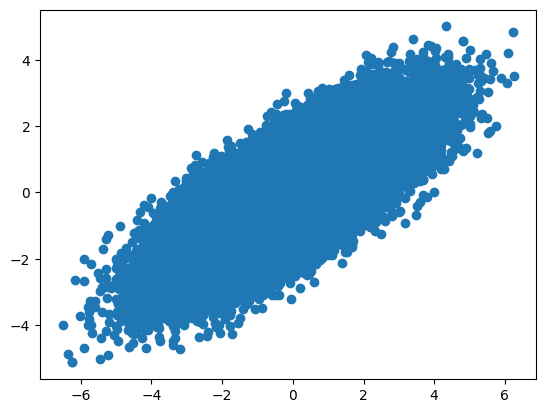

In [9]:
   
model3.eval()
inf = CausalInference(model=model3, device=device)

int_nodes_vals0 = {'X1':np.array([0.0,])}
int_nodes_vals1 = {'X1':np.array([1.0,])}
effect_var = 'Y'
effect_index = var_names3.index(effect_var)

preds0 = inf.forward(all_data3, int_nodes_vals0)
preds1 = inf.forward(all_data3, int_nodes_vals1)
ATE_pred = (preds1[:,effect_index,:] - preds0[:,effect_index,:]).mean(0)
eATE = np.abs(ATE_pred - ATE)
print('ATE:', ATE, 'est ATE:', ATE_pred, 'error:', eATE)

preds = model3(train_data.to(device))
plt.scatter(train_data[:,effect_index,-1].detach().cpu().numpy(), preds[:, effect_index, -1].detach().cpu().numpy())
print('Mean Squared Error Across All Vars:', ((train_data - preds.detach().cpu())**2).mean())
print('Mean Squared Error Across Outcome:', ((train_data[:,effect_index,:] - preds[:,effect_index,:].detach().cpu())**2).mean())